In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')
from sklearn import svm, cross_validation
import pylab as pl
from PIL import Image
import numpy as np
import os

/usr/lib/pymodules/python2.7/matplotlib/__init__.py:1173: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# Make sure that caffe is on the python path:
caffe_root = '/u/zexuan/caffe/caffe/'  # this file is expected to be in {caffe_root}/examples
caffe_real_root = '/pkgs/caffe/'
thesis_root = '/ais/gobi2/pingpong/thesis/'
#!ls /pkgs/caffe
import sys
sys.path.insert(0, caffe_real_root + 'python')
import caffe

plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

if not os.path.isfile('~/caffe/caffe/models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'):
    print("Downloading pre-trained CaffeNet model...")
    !~/caffe/caffe/scripts/download_model_binary.py ~/caffe/caffe/models/bvlc_reference_caffenet

Model already exists.


In [3]:
caffe.set_device(0)
caffe.set_mode_gpu()

In [4]:
# MODEL_FILE = caffe_root +'models/bvlc_reference_caffenet/deploy.prototxt'
# PRETRAINED = caffe_root +'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
# caffe.set_mode_cpu()
# net = caffe.Classifier(MODEL_FILE, PRETRAINED,
#                        mean=np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1),
#                        channel_swap=(2,1,0),
#                        raw_scale=255,
#                        image_dims=(600, 600))
# print net.blobs['data'].data.shape
# [(k, v.data.shape) for k, v in net.blobs.items()]


# caffe.set_mode_cpu()
print caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt'
#!ls caffe_root+'models/bvlc_reference_caffenet/deploy.prototxt'
net = caffe.Net(caffe_root + 'models/bvlc_reference_caffenet/deploy.prototxt',
                caffe_root + 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                caffe.TEST)

# input preprocessing: 'data' is the name of the input blob == net.inputs[0]
transformer = caffe.io.Transformer({'data': net.blobs['data'].data.shape})
transformer.set_transpose('data', (2,0,1))
transformer.set_mean('data', np.load(caffe_root + 'python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1)) # mean pixel
transformer.set_raw_scale('data', 255)  # the reference model operates on images in [0,255] range instead of [0,1]
transformer.set_channel_swap('data', (2,1,0))  # the reference model has channels in BGR order instead of RGB
print net.blobs['data'].data.shape
[(k, v.data.shape) for k, v in net.blobs.items()]

/u/zexuan/caffe/caffe/models/bvlc_reference_caffenet/deploy.prototxt
(10, 3, 227, 227)


[('data', (10, 3, 227, 227)),
 ('conv1', (10, 96, 55, 55)),
 ('pool1', (10, 96, 27, 27)),
 ('norm1', (10, 96, 27, 27)),
 ('conv2', (10, 256, 27, 27)),
 ('pool2', (10, 256, 13, 13)),
 ('norm2', (10, 256, 13, 13)),
 ('conv3', (10, 384, 13, 13)),
 ('conv4', (10, 384, 13, 13)),
 ('conv5', (10, 256, 13, 13)),
 ('pool5', (10, 256, 6, 6)),
 ('fc6', (10, 4096)),
 ('fc7', (10, 4096)),
 ('fc8', (10, 1000)),
 ('prob', (10, 1000))]

In [8]:
import skimage
import skimage.io
import time

start_time = time.time()
training_set = {}
training_set['target'] = []
container_path = 'labeled_img_selected_all_classes/'

folders = [f for f in sorted(os.listdir(container_path)) if os.path.isdir(os.path.join(container_path, f))]
print 'folders: ', folders

result = []
for folder in folders:
    folder_path = os.path.join(container_path, folder)
    documents = [os.path.join(folder_path, d) for d in sorted(os.listdir(folder_path))]
    input_10_imgs = []
    for pic in documents:
        if not pic.endswith('png'):
            continue
        img = skimage.img_as_float(skimage.io.imread(pic)).astype(np.float32)
        input_10_imgs.append(img)
        if len(input_10_imgs) >= 10:
            #net.blobs['data'].data[...] = transformer.preprocess('data', training_set['data'][0])
            #net.blobs['data'].data[...] = map(lambda x: transformer.preprocess('data', x), training_set['data'][i:i+10])
            net.blobs['data'].data[...] = map(lambda x: transformer.preprocess('data', x), input_10_imgs)
            out = net.forward()
            result.append(np.mean(net.blobs['fc6'].data, axis=0))
            input_10_imgs = []
        training_set['target'].append(folder)
#training_set['data']=data
#training_set['target']=target
print 'Total time loading training data: ', time.time()-start_time, ' seconds'
print 'number of images: ', len(training_set['target'])
#print 'dmensionality of each image: ', input_10_imgs[0].shape

folders:  ['C10_TOP_PLAYER_BACKHAND_BLOCK_selected', 'C11_BOTTOM_PLAYER_FOREHAND_BLOCK_selected', 'C12_BOTTOM_PLAYER_BACKHAND_BLOCK_selected', 'C13_TOP_PLAYER_FOREHAND_FLIP_selected', 'C14_TOP_PLAYER_BACKHAND_FLIP_selected', 'C15_BOTTOM_PLAYER_FOREHAND_FLIP_selected', 'C16_BOTTOM_PLAYER_BACKHAND_FLIP_selected', 'C17_TOP_PLAYER_FOREHAND_CHOP_selected', 'C18_TOP_PLAYER_BACKHAND_CHOP_selected', 'C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected', 'C1_TOP_PLAYER_FOREHAND_SERVE_selected', 'C2_TOP_PLAYER_BACKHAND_SERVE_selected', 'C30_BOTTOM_PLAYER_BACKHAND_LOB_selected', 'C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected', 'C4_BOTTOM_PLAYER_BACKHAND_SERVE_selected', 'C5_TOP_PLAYER_FOREHAND_LOOP_selected', 'C6_TOP_PLAYER_BACKHAND_LOOP_selected', 'C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected', 'C8_BOTTOM_PLAYER_BACKHAND_LOOP_selected', 'C9_TOP_PLAYER_FOREHAND_BLOCK_selected']
Total time loading training data:  1016.83592319  seconds
number of images:  22070
dmensionality of each image: 

IndexError: list index out of range

 Number of input to SVM:  2207 Size of each input (4096,)
(227, 227, 3)
Sample image from the training set


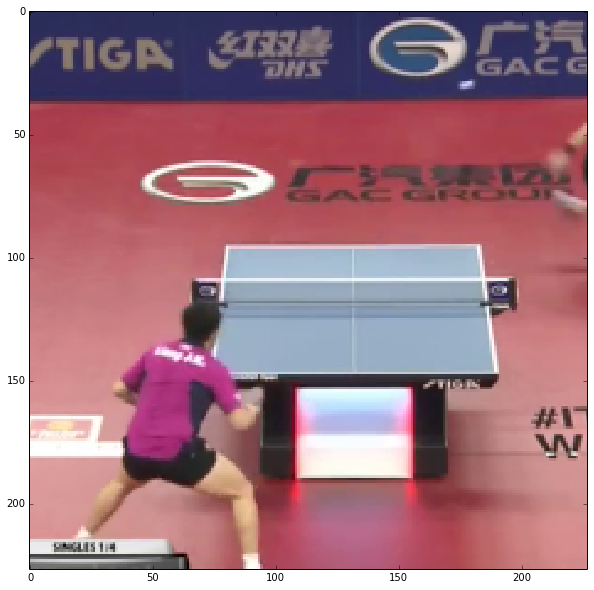

In [9]:
# print caffe.io.load_image(thesis_root + 'labeled_image_selected/bottom_player_winning_selected/point_00001_frame_00033.png').shape
# print caffe.io.load_image(thesis_root + 'labeled_image_selected/bottom_player_winning_selected/point_00001_frame_00033.png')[0][0]
# print training_set['data'][0][0][0]

'''
result = []
#for i in xrange(2200, 2300,10):
for i in xrange(0, traning_set_size, 10):
    #net.blobs['data'].data[...] = transformer.preprocess('data', training_set['data'][0])
    net.blobs['data'].data[...] = map(lambda x: transformer.preprocess('data', x), training_set['data'][i:i+10])
    out = net.forward()
    #print net.blobs['fc7'].data.shape
    result.append(np.mean(net.blobs['fc6'].data, axis=0))
'''

print 'Number of input to SVM: ', len(result), 'Size of each input', result[0].shape

print transformer.deprocess('data', net.blobs['data'].data[0]).shape
print 'Sample image from the training set'
plt.imshow(transformer.deprocess('data', net.blobs['data'].data[4]))

In [11]:
import pickle

pickle.dump(result, open("nn_result_fc6_unnormalized_clf_7videos.pickle", "wb" ) )

In [12]:
#from sklearn.preprocessing import normalize
print len(result)
print np.max(result[0])
print result[0].shape
normalized_result = []
#normalized_result = normalize(result)
for r in result:
    #normalized_result.append(r/np.max(r))
    normalized_result.append((r-np.mean(r))/np.std(r))

2207
49.2432
46.0859
(4096,)


In [13]:
import pickle

pickle.dump(normalized_result, open("nn_result_fc6_normalized_clf_7videos.pickle", "wb" ) )

In [14]:
print len(normalized_result)
print np.max(normalized_result[0])
print normalized_result[0].shape
print result[0].shape


2207
14.806
14.8732
(4096,)
(4096,)


In [17]:
from sklearn import decomposition

traning_set_size = len(training_set['target'])
#X_train, X_test, y_train, y_test = cross_validation.train_test_split(result, training_set['target'][0:traning_set_size:10], test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test = cross_validation.train_test_split(normalized_result, training_set['target'][0:traning_set_size:10], test_size=0.25, random_state=42)

print 'X_train: %d; X_test: %d; y_train: %d; y_test: %d'%(len(X_train), len(X_test), len(y_train), len(y_test))

X_train: 1655; X_test: 552; y_train: 1655; y_test: 552


In [18]:
for c in [0.00001, 0.001, 0.005, 0.01, 0.05, 0.1, 1, 10, 100, 1000]:
    svc = svm.SVC(kernel='linear', C=c) 
    kfold = cross_validation.KFold(len(X_train), n_folds=4, shuffle=False)
    cv_result = cross_validation.cross_val_score(svc, X_train, y_train, cv=kfold, n_jobs=1)
    print 'C = %g, Cross validation: %s'%(c, cv_result)
    print 'C = %g, Mean value: %g'%(c, np.mean(cv_result))

C = 1e-05, Cross validation: [ 0.43478261  0.45652174  0.39130435  0.37772397]
C = 1e-05, Mean value: 0.415083
C = 0.001, Cross validation: [ 0.83091787  0.81884058  0.83574879  0.79661017]
C = 0.001, Mean value: 0.820529
C = 0.005, Cross validation: [ 0.90096618  0.89130435  0.91062802  0.85472155]
C = 0.005, Mean value: 0.889405
C = 0.01, Cross validation: [ 0.90096618  0.90821256  0.9178744   0.85472155]
C = 0.01, Mean value: 0.895444
C = 0.05, Cross validation: [ 0.88888889  0.9057971   0.90096618  0.84503632]
C = 0.05, Mean value: 0.885172
C = 0.1, Cross validation: [ 0.89371981  0.9057971   0.89371981  0.84503632]
C = 0.1, Mean value: 0.884568
C = 1, Cross validation: [ 0.87922705  0.89855072  0.88888889  0.83050847]
C = 1, Mean value: 0.874294
C = 10, Cross validation: [ 0.87198068  0.88888889  0.86714976  0.82566586]
C = 10, Mean value: 0.863421
C = 100, Cross validation: [ 0.87198068  0.88888889  0.86714976  0.82566586]
C = 100, Mean value: 0.863421
C = 1000, Cross validation:

In [19]:
for c in [0.001, 0.005, 0.01, 0.05, 0.1, 1, 2.5, 5, 7.5, 10, 50, 100, 1000, 10000]:
    svc = svm.SVC(C=c, kernel='rbf')
    kfold = cross_validation.KFold(len(X_train), n_folds=4, shuffle=False)
    cv_result = cross_validation.cross_val_score(svc, X_train, y_train, cv=kfold, n_jobs=1)
    print 'C = %g, Cross validation: %s'%(c, cv_result)
    print 'C = %g, Mean value: %g'%(c, np.mean(cv_result))

C = 0.001, Cross validation: [ 0.25845411  0.24396135  0.22705314  0.22276029]
C = 0.001, Mean value: 0.238057
C = 0.005, Cross validation: [ 0.25845411  0.24396135  0.22705314  0.22276029]
C = 0.005, Mean value: 0.238057
C = 0.01, Cross validation: [ 0.25845411  0.24396135  0.22705314  0.22276029]
C = 0.01, Mean value: 0.238057
C = 0.05, Cross validation: [ 0.5821256   0.5531401   0.52415459  0.51815981]
C = 0.05, Mean value: 0.544395
C = 0.1, Cross validation: [ 0.61594203  0.56763285  0.56763285  0.53753027]
C = 0.1, Mean value: 0.572184
C = 1, Cross validation: [ 0.78985507  0.74879227  0.76811594  0.72639225]
C = 1, Mean value: 0.758289
C = 2.5, Cross validation: [ 0.83816425  0.80917874  0.84057971  0.79903148]
C = 2.5, Mean value: 0.821739
C = 5, Cross validation: [ 0.87198068  0.85990338  0.87681159  0.83050847]
C = 5, Mean value: 0.859801
C = 7.5, Cross validation: [ 0.89130435  0.86714976  0.90096618  0.84987893]
C = 7.5, Mean value: 0.877325
C = 10, Cross validation: [ 0.905

In [20]:
for c in [0.01, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]:
    svc = svm.SVC(C=c, kernel='poly', degree=1)
    kfold = cross_validation.KFold(len(X_train), n_folds=4, shuffle=False)
    cv_result = cross_validation.cross_val_score(svc, X_train, y_train, cv=kfold, n_jobs=1)
    print 'C = %g, Cross validation: %s'%(c, cv_result)
    print 'C = %g, Mean value: %g'%(c, np.mean(cv_result))

C = 0.01, Cross validation: [ 0.25845411  0.24396135  0.22705314  0.22276029]
C = 0.01, Mean value: 0.238057
C = 0.05, Cross validation: [ 0.51207729  0.50724638  0.40821256  0.44552058]
C = 0.05, Mean value: 0.468264
C = 0.1, Cross validation: [ 0.60144928  0.56038647  0.5531401   0.53995157]
C = 0.1, Mean value: 0.563732
C = 1, Cross validation: [ 0.76811594  0.70772947  0.7294686   0.68765133]
C = 1, Mean value: 0.723241
C = 10, Cross validation: [ 0.86956522  0.87198068  0.87922705  0.83292978]
C = 10, Mean value: 0.863426
C = 100, Cross validation: [ 0.88888889  0.90821256  0.9057971   0.8401937 ]
C = 100, Mean value: 0.885773
C = 1000, Cross validation: [ 0.87922705  0.90096618  0.89130435  0.83292978]
C = 1000, Mean value: 0.876107
C = 10000, Cross validation: [ 0.87439614  0.89613527  0.88164251  0.82082324]
C = 10000, Mean value: 0.868249
C = 100000, Cross validation: [ 0.87198068  0.88888889  0.86714976  0.82566586]
C = 100000, Mean value: 0.863421
C = 1e+06, Cross validation

In [21]:
for c in [0.01, 0.05, 0.1, 1, 10, 100, 1000, 10000, 100000, 1000000]:
    svc = svm.SVC(C=c, kernel='poly', degree=3)
    kfold = cross_validation.KFold(len(X_train), n_folds=4, shuffle=False)
    cv_result = cross_validation.cross_val_score(svc, X_train, y_train, cv=kfold, n_jobs=1)
    print 'C = %g, Cross validation: %s'%(c, cv_result)
    print 'C = %g, Mean value: %g'%(c, np.mean(cv_result))

C = 0.01, Cross validation: [ 0.25845411  0.24396135  0.22705314  0.22276029]
C = 0.01, Mean value: 0.238057
C = 0.05, Cross validation: [ 0.59661836  0.56763285  0.55797101  0.53753027]
C = 0.05, Mean value: 0.564938
C = 0.1, Cross validation: [ 0.64251208  0.57729469  0.59661836  0.55932203]
C = 0.1, Mean value: 0.593937
C = 1, Cross validation: [ 0.81400966  0.77536232  0.80434783  0.7433414 ]
C = 1, Mean value: 0.784265
C = 10, Cross validation: [ 0.89613527  0.89130435  0.91062802  0.85714286]
C = 10, Mean value: 0.888803
C = 100, Cross validation: [ 0.88405797  0.89371981  0.88647343  0.8401937 ]
C = 100, Mean value: 0.876111
C = 1000, Cross validation: [ 0.87439614  0.88647343  0.88405797  0.83050847]
C = 1000, Mean value: 0.868859
C = 10000, Cross validation: [ 0.8647343   0.88164251  0.87439614  0.82566586]
C = 10000, Mean value: 0.86161
C = 100000, Cross validation: [ 0.8647343   0.88164251  0.87198068  0.82566586]
C = 100000, Mean value: 0.861006
C = 1e+06, Cross validation:

In [22]:
from sklearn import svm, cross_validation
X_train = np.asarray(X_train)
svc = svm.SVC(kernel='precomputed')
kernel_train = np.dot(X_train, X_train.T)  # linear kernel
svc.fit(kernel_train, y_train)

# Testing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
kernel_test = np.dot(X_test, X_train.T)
y_pred = svc.predict(kernel_test)
print accuracy_score(y_test, y_pred)

import pandas as pd
y_true = pd.Series(y_test)
y_pred = pd.Series(y_pred)

#print pd.crosstab(y_true, y_pred, rownames=['True'], colnames=['Predicted'], margins=True)

print confusion_matrix(y_test, y_pred).shape
print confusion_matrix(y_test, y_pred)
#print '\n'.join(sorted(list(set(y_test))))
print len(set(y_test).union(set(y_pred)))

0.882246376812
(18, 18)
[[  4   0   0   0   0   0   0   0   1   0   1   0   0   0   0   0   0   0]
 [  0   5   0   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0]
 [  0   0   4   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   2   0   0   0   0   0   1   0   0   0   0]
 [  0   0   0   0   7   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   1   0   0  26   0   3   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  16   2   0   0   0   0   0   0   0   0]
 [  0   0   0   0   1   1   0   2   0 114   6   0   7   6   0   2   0   0]
 [  0   0   0   0   0   0   0   0   0   1  89   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0  10   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   4   0   0 102   0   0   0   0   0]
 

/u/zexuan/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2641: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [23]:
clf_best = svm.SVC(kernel='poly', C=10, degree=1).fit(X_train, y_train)
clf_best.score(X_test, y_test)

0.88405797101449279

In [24]:
print len(X_test)
print len(y_test)
for i,_ in enumerate(X_test):
    if clf_best.predict(X_test[i])[0] == y_test[i]:
        print 'SAME: ', clf_best.predict(X_test[i])[0]
    else:
        print 'DIFFERENT: ', clf_best.predict(X_test[i])[0], y_test[i]
        

552
552
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
DIFFERENT:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected C5_TOP_PLAYER_FOREHAND_LOOP_selected
DIFFERENT:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
DIFFERENT: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  C5_TOP_PLAYER_FOREHAND_LOOP_selected C8_BOTTOM_PLAYER_BACKHAND_LOOP_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C30_BOTTOM_PLAYER_BACKHAND_LOB_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C18_TOP_PLAYER_BACKHAND_CHOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C6_TOP_PLAYER_BACKHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
DIFFERENT:  C18_TOP_PLAYER_BACKHAND_CHOP_selected C10_TOP_PLAYER_BACKHAND_BLOCK_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C18_TOP_PLAYER_BACKHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C18_TOP_PLAYER_BACKHAND_CHOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C9_TOP_PLAYER_FOREHAND_BLOCK_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C30_BOTTOM_PLAYER_BACKHAND_LOB_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C14_TOP_PLAYER_BACKHAND_FLIP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
DIFFERENT:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C1_TOP_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected C6_TOP_PLAYER_BACKHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C14_TOP_PLAYER_BACKHAND_FLIP_selected
SAME:  C18_TOP_PLAYER_BACKHAND_CHOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
DIFFERENT: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C6_TOP_PLAYER_BACKHAND_LOOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
DIFFERENT: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected C5_TOP_PLAYER_FOREHAND_LOOP_selected
DIFFERENT:  C6_TOP_PLAYER_BACKHAND_LOOP_selected C14_TOP_PLAYER_BACKHAND_FLIP_selected
DIFFERENT:  C18_TOP_PLAYER_BACKHAND_CHOP_selected C6_TOP_PLAYER_BACKHAND_LOOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
DIFFERENT: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C5_TOP_PLAYER_FOREHAND_LOOP_selected C8_BOTTOM_PLAYER_BACKHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  C17_TOP_PLAYER_FOREHAND_CHOP_selected C13_TOP_PLAYER_FOREHAND_FLIP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C18_TOP_PLAYER_BACKHAND_CHOP_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C18_TOP_PLAYER_BACKHAND_CHOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C1_TOP_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C12_BOTTOM_PLAYER_BACKHAND_BLOCK_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C18_TOP_PLAYER_BACKHAND_CHOP_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C1_TOP_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C5_TOP_PLAYER_FOREHAND_LOOP_selected
DIFFERENT:  C6_TOP_PLAYER_BACKHAND_LOOP_selected C18_TOP_PLAYER_BACKHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C30_BOTTOM_PLAYER_BACKHAND_LOB_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C6_TOP_PLAYER_BACKHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C18_TOP_PLAYER_BACKHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C6_TOP_PLAYER_BACKHAND_LOOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C11_BOTTOM_PLAYER_FOREHAND_BLOCK_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C18_TOP_PLAYER_BACKHAND_CHOP_selected
SAME: 

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

 C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C30_BOTTOM_PLAYER_BACKHAND_LOB_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
DIFFERENT:  C17_TOP_PLAYER_FOREHAND_CHOP_selected C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C8_BOTTOM_PLAYER_BACKHAND_LOOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C11_BOTTOM_PLAYER_FOREHAND_BLOCK_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C11_BOTTOM_PLAYER_FOREHAND_BLOCK_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C18_TOP_PLAYER_BACKHAND_CHOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
DIFFERENT:  C17_TOP_PLAYER_FOREHAND_CHOP_selected C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C18_TOP_PLAYER_BACKHAND_CHOP_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C11_BOTTOM_PLAYER_FOREHAND_BLOCK_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C30_BOTTOM_PLAYER_BACKHAND_LOB_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C8_BOTTOM_PLAYER_BACKHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  C17_TOP_PLAYER_FOREHAND_CHOP_selected C13_TOP_PLAYER_FOREHAND_FLIP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C18_TOP_PLAYER_BACKHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C6_TOP_PLAYER_BACKHAND_LOOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
DIFFERENT:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C18_TOP_PLAYER_BACKHAND_CHOP_selected
SAME:  C14_TOP_PLAYER_BACKHAND_FLIP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
DIFFERENT:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C12_BOTTOM_PLAYER_BACKHAND_BLOCK_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C10_TOP_PLAYER_BACKHAND_BLOCK_selected C9_TOP_PLAYER_FOREHAND_BLOCK_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  C30_BOTTOM_PLAYER_BACKHAND_LOB_selected C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
DIFFERENT:  C18_TOP_PLAYER_BACKHAND_CHOP_selected C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C9_TOP_PLAYER_FOREHAND_BLOCK_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
DIFFERENT:  C17_TOP_PLAYER_FOREHAND_CHOP_selected C6_TOP_PLAYER_BACKHAND_LOOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C9_TOP_PLAYER_FOREHAND_BLOCK_selected
DIFFERENT:  C17_TOP_PLAYER_FOREHAND_CHOP_selected C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C18_TOP_PLAYER_BACKHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C10_TOP_PLAYER_BACKHAND_BLOCK_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C6_TOP_PLAYER_BACKHAND_LOOP_selected
SAME:  C16_BOTTOM_PLAYER_BACKHAND_FLIP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
DIFFERENT:  C18_TOP_PLAYER_BACKHAND_CHOP_selected C14_TOP_PLAYER_BACKHAND_FLIP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C6_TOP_PLAYER_BACKHAND_LOOP_selected
SAME:  C6_TOP_PLAYER_BACKHAND_LOOP_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C9_TOP_PLAYER_FOREHAND_BLOCK_selected
DIFFERENT:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C6_TOP_PLAYER_BACKHAND_LOOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C30_BOTTOM_PLAYER_BACKHAND_LOB_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C12_BOTTOM_PLAYER_BACKHAND_BLOCK_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C9_TOP_PLAYER_FOREHAND_BLOCK_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C6_TOP_PLAYER_BACKHAND_LOOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C6_TOP_PLAYER_BACKHAND_LOOP_selected C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C6_TOP_PLAYER_BACKHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
DIFFERENT:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C5_TOP_PLAYER_FOREHAND_LOOP_selected C10_TOP_PLAYER_BACKHAND_BLOCK_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C6_TOP_PLAYER_BACKHAND_LOOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C11_BOTTOM_PLAYER_FOREHAND_BLOCK_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C12_BOTTOM_PLAYER_BACKHAND_BLOCK_selected
DIFFERENT:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C5_TOP_PLAYER_FOREHAND_LOOP_selected C13_TOP_PLAYER_FOREHAND_FLIP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  C5_TOP_PLAYER_FOREHAND_LOOP_selected C6_TOP_PLAYER_BACKHAND_LOOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C18_TOP_PLAYER_BACKHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
DIFFERENT:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C6_TOP_PLAYER_BACKHAND_LOOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
DIFFERENT:  C1_TOP_PLAYER_FOREHAND_SERVE_selected C10_TOP_PLAYER_BACKHAND_BLOCK_selected
DIFFERENT:  C1_TOP_PLAYER_FOREHAND_SERVE_selected C5_TOP_PLAYER_FOREHAND_LOOP_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C8_BOTTOM_PLAYER_BACKHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C14_TOP_PLAYER_BACKHAND_FLIP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C18_TOP_PLAYER_BACKHAND_CHOP_selected
SAME:  C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C10_TOP_PLAYER_BACKHAND_BLOCK_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C14_TOP_PLAYER_BACKHAND_FLIP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C10_TOP_PLAYER_BACKHAND_BLOCK_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  C6_TOP_PLAYER_BACKHAND_LOOP_selected C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C17_TOP_PLAYER_FOREHAND_CHOP_selected
SAME:  C30_BOTTOM_PLAYER_BACKHAND_LOB_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C9_TOP_PLAYER_FOREHAND_BLOCK_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C8_BOTTOM_PLAYER_BACKHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C30_BOTTOM_PLAYER_BACKHAND_LOB_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C1_TOP_PLAYER_FOREHAND_SERVE_selected
DIFFERENT:  C12_BOTTOM_PLAYER_BACKHAND_BLOCK_selected C7_BOTTOM_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C30_BOTTOM_PLAYER_BACKHAND_LOB_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C1_TOP_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C30_BOTTOM_PLAYER_BACKHAND_LOB_selected
SAME:  

/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
SAME:  C11_BOTTOM_PLAYER_FOREHAND_BLOCK_selected
SAME:  C5_TOP_PLAYER_FOREHAND_LOOP_selected
SAME:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected
DIFFERENT:  C19_BOTTOM_PLAYER_FOREHAND_CHOP_selected C18_TOP_PLAYER_BACKHAND_CHOP_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected
SAME:  C3_BOTTOM_PLAYER_FOREHAND_SERVE_selected


/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationW

In [25]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
clf = neigh.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8188405797101449

In [26]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
clf = gnb.fit(X_train, y_train)
clf.score(X_test, y_test)

0.67572463768115942

In [27]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
clf = lr.fit(X_train, y_train)
clf.score(X_test, y_test)

0.89673913043478259

In [28]:
#predict_probability = clf.predict_proba(X_test)
#print predict_probability[0]
#print sum(predict_probability[0]

print X_test[0]
print clf.predict(X_test[0])

[ 1.67686987  5.14637995 -0.28970283 ..., -0.28970283 -0.28970283
 -0.28970283]
['C5_TOP_PLAYER_FOREHAND_LOOP_selected']


/u/zexuan/.local/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [29]:
pickle.dump(clf, open("fc6_normalized_lr_clf_7videos.pickle", "wb" ) )

In [ ]:
from pystruct.learners import NSlackSSVM
from pystruct.models import GraphCRF
#from sklearn.datasets import load_iris

#iris = load_iris()
#X, y = iris.data, iris.target


#y_train = list(y_train)
y_train_int = [int(y[1:y.find('_')]) for y in y_train]

#print y_train_int

unique_labels = sorted(list(set(y_train_int)))
label_to_ind_dict = {}
for i,l in enumerate(unique_labels):
    label_to_ind_dict[l] = i
print label_to_ind_dict
y_train_int = [label_to_ind_dict[l] for y in y_train_int]

y_train_int = np.asarray(y_train_int).reshape(-1,1)
#print X_train.shape, y_train_int.shape

X_train_CRF = [(np.atleast_2d(x), np.empty((0, 2), dtype=np.int)) for x in X_train]
y_train_CRF = y_train_int.reshape(-1, 1)
pbl = GraphCRF(inference_method='unary')
svm = NSlackSSVM(pbl, C=100)
svm.fit(X_train_CRF, y_train_CRF)
